# TP  Evolution de la population des communes françaises 

Cody ADAM

Février 2023 

Objectifs du TP 
----------------

+ Utiliser le module pandas et les structures de données qu'il introduit (au dessus de numpy)
    + Séries 
    + DataFrame 
+ Pratiquer pandas sur un cas concret (études des communes françaises)
    + Lecture 
    + Mise en forme, gestion des données invalides
    + Association entre différentes sources de données (merge) 
    + Visualisation (scatter plot)
    
    

#  Etude des Communes Françaises

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


Vous disposez sur moodle d'une archive contenant différents fichiers sélectionnés pour les besoins du TP. 
En particulier: 

+  `commune1.csv` est un fichier qui contient l'évolution démographique de toutes les communes française depuis 1975 ainsi que les coordonnées géographiques (longitude,latitude) de la commune. Ce fichier est volumineux et découpés en 2 archives zip.
+ `commune2.csv`est un fichier d'une autre source qui contient entre autres les codes postaux des communes 
+ `maires-25-04-2014.xslx` contient la liste des maires de France. 
+ `insee.csv` 


Sur la figure ci-dessous chaque point correspond à une commune. 

## Lecture de fichiers

In [2]:
commune = pd.read_csv("commune1.csv", sep=",", encoding="utf-8")
insee = pd.read_csv("Insee.csv", sep=";", encoding="utf-8")
maires = pd.read_excel("maires.xlsx", skiprows=3)

In [3]:
commune.head()

reg  dep  com article                     com_nom      long        lat  \
0   11   75   56     NaN                       PARIS  2.352222  48.856614   
1   11   77    1     NaN            ACHERES-LA-FORET  2.570289  48.354976   
2   11   77   10     NaN  AUBEPIERRE-OZOUER-LE-REPOS  2.890552  48.632323   
3   11   77  100      LE            CHATELET-EN-BRIE  2.792095  48.504945   
4   11   77  101     NaN          CHATENAY-SUR-SEINE  3.096229  48.418774   

       pop_1975      pop_1976      pop_1977  ...      pop_2001      pop_2002  \
0  2.294116e+06  2.277408e+06  2.261510e+06  ...  2.142425e+06  2.149205e+06   
1  6.482592e+02  6.620875e+02  6.763429e+02  ...  1.106389e+03  1.126294e+03   
2  5.874394e+02  5.995405e+02  6.118238e+02  ...  8.738642e+02  8.797754e+02   
3  2.251402e+03  2.481846e+03  2.695300e+03  ...  4.408286e+03  4.407891e+03   
4  5.071603e+02  5.391894e+02  5.699313e+02  ...  9.284420e+02  9.278621e+02   

       pop_2003      pop_2004      pop_2005      pop_2006      pop_2007  \
0  2.156989e+06  2.165785e+06  2.175600e+06  2.186440e+06  2.198315e+06   
1  1.146224e+03  1.166163e+03  1.186095e+03  1.206006e+03  1.225880e+03   
2  8.849946e+02  8.894883e+02  8.932229e+02  8.961646e+02  8.982798e+02   
3  4.407379e+03  4.407398e+03  4.408599e+03  4.411630e+03  4.417140e+03   
4  9.260636e+02  9.230492e+02  9.188215e+02  9.133832e+02  9.067369e+02   

       pop_2008      pop_2009      pop_2010  
0  2.211230e+06  2.225194e+06  2.240213e+06  
1  1.245702e+03  1.265455e+03  1.285127e+03  
2  8.995351e+02  8.998966e+02  8.993365e+02  
3  4.425779e+03  4.438194e+03  4.454928e+03  
4  8.988853e+02  8.898310e+02  8.795762e+02  

[5 rows x 43 columns]

In [4]:
insee.head()

Commune Codepos Departement  INSEE
0  ABERGEMENT CLEMENCIAT   01400         AIN   1001
1    ABERGEMENT DE VAREY   01640         AIN   1002
2               AMAREINS   01090         AIN   1003
3      AMBERIEU EN BUGEY   01500         AIN   1004
4    AMBERIEUX EN DOMBES   01330         AIN   1005

In [5]:

maires.head()

Code du département (Maire) Libellé de département (Maires)  \
0                           1                             AIN   
1                           1                             AIN   
2                           1                             AIN   
3                           1                             AIN   
4                           1                             AIN   

  Code Insee de la commune    Libellé de la commune  Population de la commune  \
0                        1  L'Abergement-Clémenciat                     780.0   
1                        2    L'Abergement-de-Varey                     234.0   
2                        4        Ambérieu-en-Bugey                   13839.0   
3                        5      Ambérieux-en-Dombes                    1600.0   
4                        6                  Ambléon                     112.0   

  Nom de l'élu Prénom de l'élu Civilité Date de naissance  Code profession  \
0       BOULON          Daniel        M        1951-03-04             61.0   
1        ORSET             Max        M        1947-11-02             65.0   
2        FABRE          Daniel        M        1961-09-07             51.0   
3       PERNET          Pierre        M        1961-07-29             42.0   
4       BIONDA           Annie      Mme        1951-11-28             63.0   

                Libellé de la profession  
0              Retraités salariés privés  
1                       Autres retraités  
2         Cadres (entreprises publiques)  
3    Professeurs du secondaire et techn.  
4  Retraités fonct.publique (sf enseig.)

## Nettoyage et fusion (Merge) de tous les `DataFrame`

On ajoute le code INSEE à toutes les tables s'il n'est pas déjà présent. Cette colonne sera notre pivot pour les jointures.

Le code INSEE est composé de 5 chiffres.

`<Code INSEE> = <Code département> * 1000 + <Code commune>`

In [22]:
commune["INSEE"] = commune.apply(lambda x: int(x["dep"]) * 1000 + int(x["com"]), axis=1)

# remove any non numeric department code
maires = maires[maires["Code du département (Maire)"].apply(lambda x: str(x).isnumeric())]
maires["INSEE"] = maires.apply(lambda x: int(x["Code du département (Maire)"]) * 1000 + int(x["Code Insee de la commune"]), axis=1)


In [39]:
com = commune.merge(insee, on="INSEE", how="inner")
com = com.merge(maires, on="INSEE", how="inner")

com.head()

reg  dep  com article                     com_nom      long        lat  \
0   11   77    1     NaN            ACHERES-LA-FORET  2.570289  48.354976   
1   11   77   10     NaN  AUBEPIERRE-OZOUER-LE-REPOS  2.890552  48.632323   
2   11   77  100      LE            CHATELET-EN-BRIE  2.792095  48.504945   
3   11   77  101     NaN          CHATENAY-SUR-SEINE  3.096229  48.418774   
4   11   77  102     NaN                    CHATENOY  2.625239  48.233563   

      pop_1975     pop_1976     pop_1977  ...  \
0   648.259242   662.087472   676.342899  ...   
1   587.439368   599.540499   611.823807  ...   
2  2251.401706  2481.846183  2695.299617  ...   
3   507.160272   539.189398   569.931319  ...   
4   131.539347   127.684799   124.269462  ...   

   Libellé de département (Maires)  Code Insee de la commune  \
0                  SEINE ET MARNE                          1   
1                  SEINE ET MARNE                         10   
2                  SEINE ET MARNE                        100   
3                  SEINE ET MARNE                        101   
4                  SEINE ET MARNE                        102   

        Libellé de la commune  Population de la commune  Nom de l'élu  \
0            Achères-la-Forêt                    1232.0      MALCHERE   
1  Aubepierre-Ozouer-le-Repos                     895.0       CUYPERS   
2         Le Châtelet-en-Brie                    4413.0        MAZARD   
3          Châtenay-sur-Seine                     955.0         BIGOT   
4                    Châtenoy                     155.0       CELADON   

   Prénom de l'élu  Civilité  Date de naissance  Code profession  \
0          Patrice         M         1953-07-03              1.0   
1           Pierre         M         1944-03-23              1.0   
2            Alain         M         1943-11-01             61.0   
3        Jean Yves         M         1947-08-12             65.0   
4            Denis         M         1962-04-23             51.0   

              Libellé de la profession  
0  Agriculteurs propriétaires exploit.  
1  Agriculteurs propriétaires exploit.  
2            Retraités salariés privés  
3                     Autres retraités  
4       Cadres (entreprises publiques)  

[5 rows x 58 columns]

## Affichage de la densité de population en France en 1975

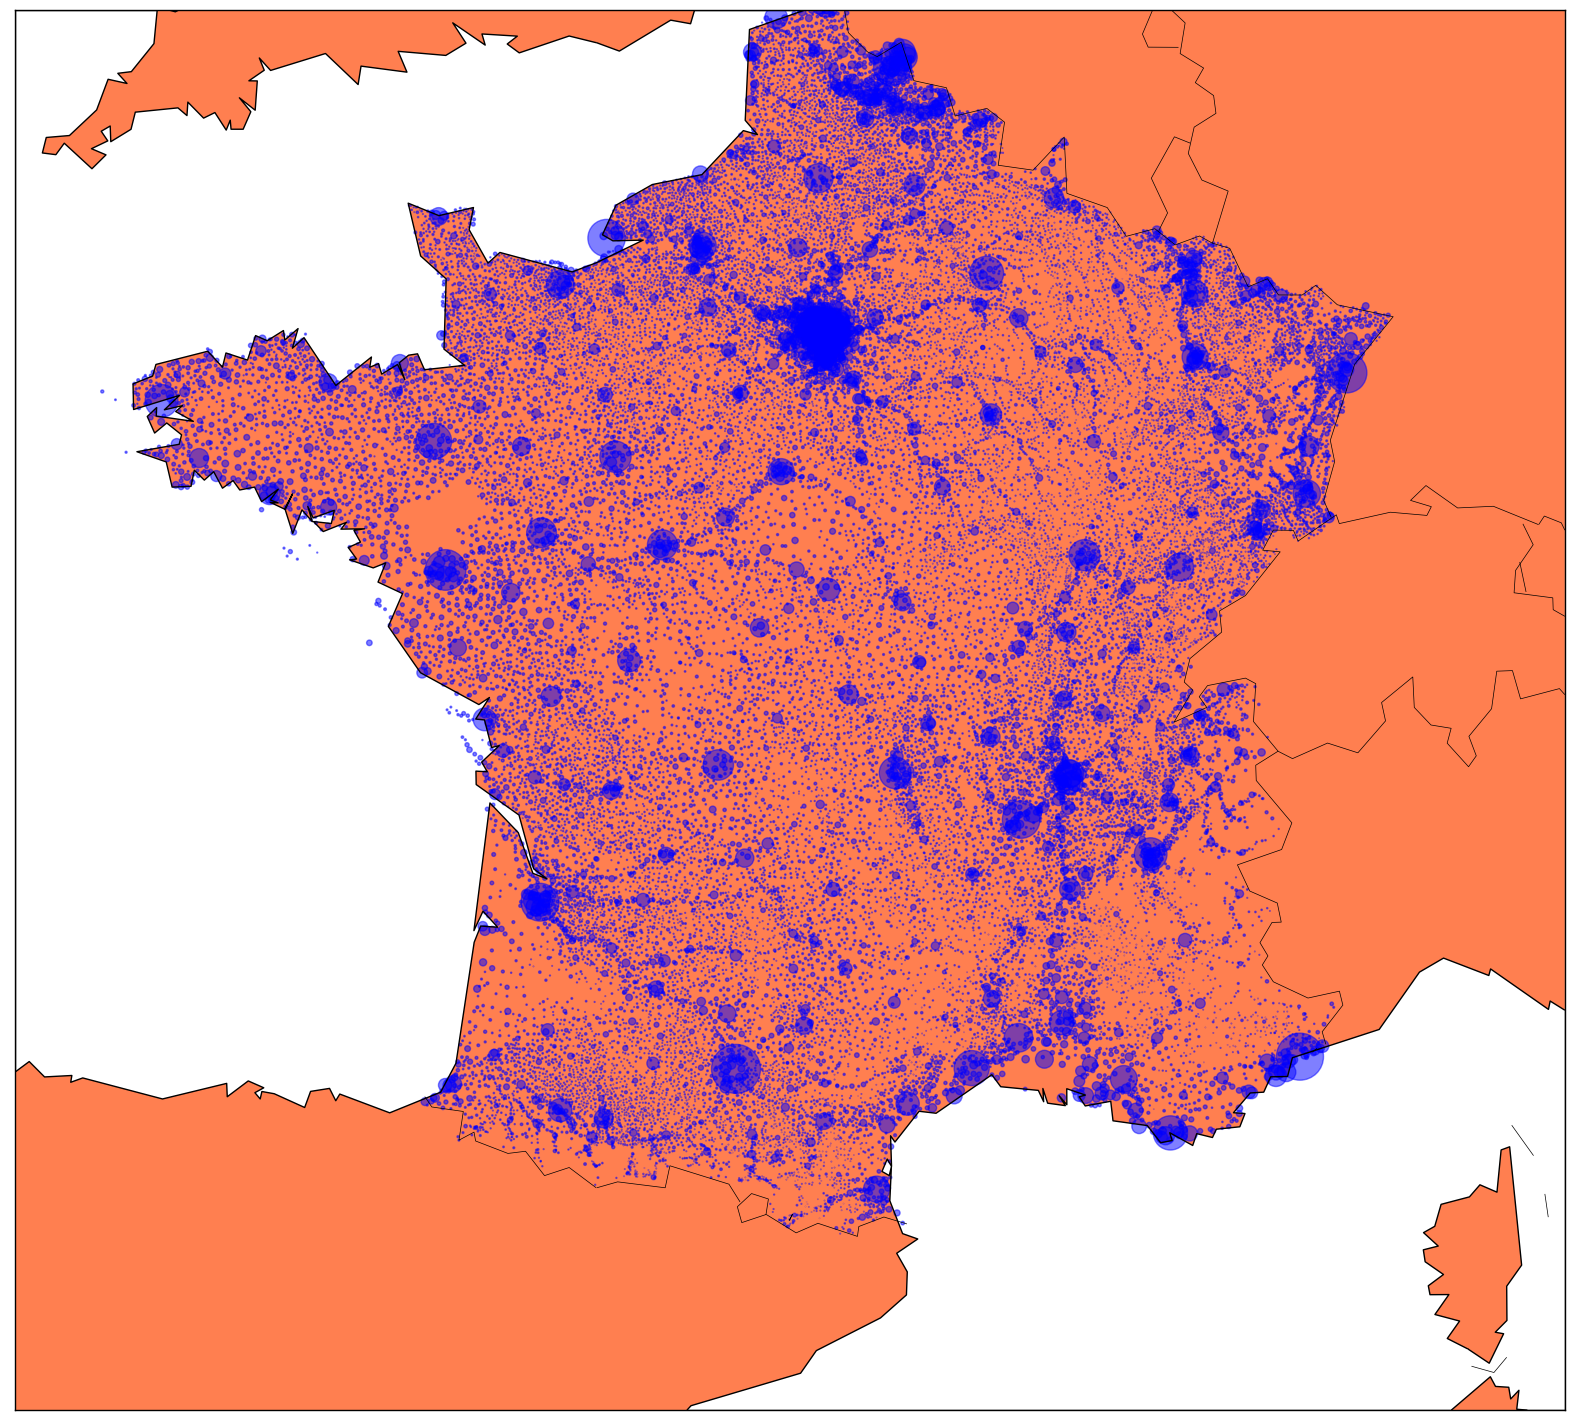

In [40]:

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=41, urcrnrlat=51, llcrnrlon=-6, urcrnrlon=10, lat_ts=20, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.fillcontinents(color='coral',lake_color='aqua')

x, y = m(com["long"].values, com["lat"].values)
pop = com["pop_1975"].values
size = pop/300
plt.scatter(x, y, s=size, c="blue", alpha=0.5)




## Affichage des communes selon l'âge de leur maire

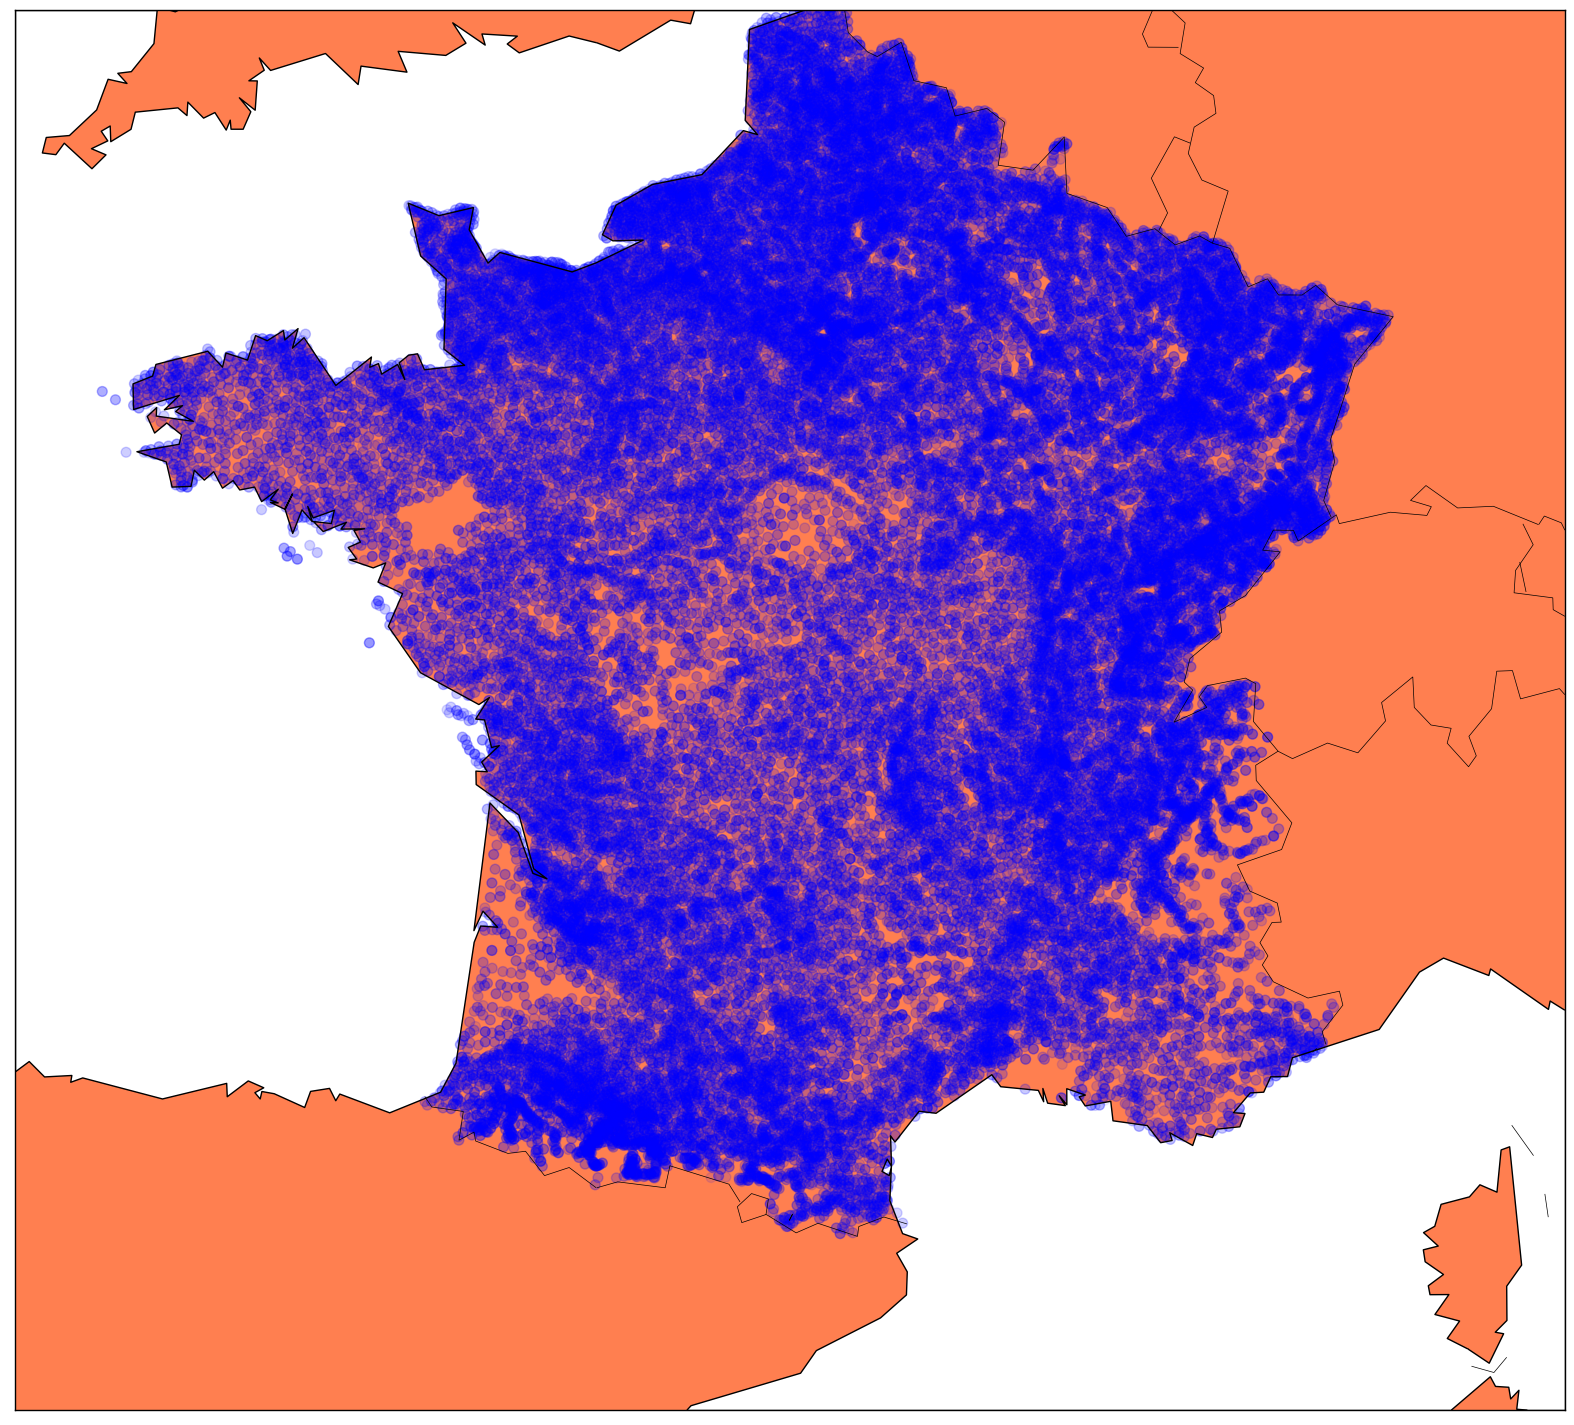

In [71]:

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=41, urcrnrlat=51, llcrnrlon=-6, urcrnrlon=10, lat_ts=20, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.fillcontinents(color='coral',lake_color='aqua')

x, y = m(com["long"].values, com["lat"].values)
birthDate = com["Date de naissance"].values
now = pd.to_datetime("now", utc=True)
age = now.year - pd.to_datetime(birthDate).year

minAge = age.min()
maxAge = age.max()

# t from age (min-max) -> (0.0-1.0)
t = (age - minAge) / (maxAge - minAge)
size = 3 + 100 * t
plt.scatter(x, y, s=50, c="blue", alpha=(1-t)*.6)

## Analyse demandées

+ Construire une fonction qui évalue le taux de croissance de la population entre deux années consécutives. 

+ Visualiser avec la fonction `plt.scatter` la croissance ou la décroissance de la population
+ Proposer des visualisations de la répartition des communes en fonction de différents critères (superficie, prénom du maire, ...)